# Домашнее задание 5

Ссылка на семинар: https://colab.research.google.com/drive/1_G8kdmhtokmAUeMsSrl1IKqIs3_FEbeK?usp=sharing

Не забудьте поставить видеокарту в качестве аппаратного ускорителя :)

### Сохранение и загрузка

[3 балла] 

Сделайте сохранение моделей после обучения (в формате .pth). В случае маленьких сетей на маленьких данных в этом нет необходимости, но в других случаях можно сохранять версию модели (checkpoint) каждые несколько (к примеру 5) эпох. Сделайте и протестируйте загрузку моделей для задачи классификации рукописных цифр.

### Сверточная сеть на CIFAR-10

[5 баллов]

Решите задачу классификации на другом датасете - CIFAR-10 https://en.wikipedia.org/wiki/CIFAR-10
В примерах к Pytorch есть полное решение этой задачи, но попробуйте придумать его самостоятельно. Этот датасет отличается от mnist тем, что изображения в нём имеют размер не 28x28, а 32x32x3, то есть они трёхканальные, "цветные". Для того, чтобы сеть заработала и начала хотя бы как-то учиться, нужно сделать так, чтобы размеры (shapes) тензоров на выходе предыдущего слоя совпадали с размером тензоров на входе следующего слоя.

### Классификация на своих картинках

[6 баллов]

Запустите распознавание цифр на самостоятельно записанных данных. Можно использовать фотографию листочка, можно просто нарисовать их в пейнте. Чтобы все заработало, нужнро во-первых помнить, что сеть, созданная для работы с mnist, принимает на вход одноканальные картинки 28x28, а во-вторых учесть, что границы цифр в обучающих данных не резкие, в процессе их подготовки был применён антиалеасинг.

### Загадка

Доп.задача 1 [5 баллов]

Найдите, почему при обучении свёрточной сети (Conv_net в семинаре) test loss всё время меньше train loss-а. Напишите, почему так получается, исправьте ошибку, если она есть. Обратите внимание, что при обучении Simple_net такого не наблюдается.

In [3]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

In [4]:
batch_size = 100
no_cuda         = False
use_cuda = not no_cuda and torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


Extracting ../data/cifar-10-python.tar.gz to ../data


In [35]:
for i, (data,target) in enumerate(train_loader):
  print(data.shape)
  print(type(target))
  break

torch.Size([100, 3, 32, 32])
<class 'torch.Tensor'>


In [5]:
class Net(nn.Module):
    def __init__(self, hidden, out_sz):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(28**2, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, out_sz)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.leaky_relu (x)

        x = self.fc2(x)
        x = F.leaky_relu (x)
        
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)

        return output

class Conv_net(nn.Module):
    def __init__(self):
        super(Conv_net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1,padding=1)
        self.act1=nn.ReLU()
        self.conv2 = nn.Conv2d(32, 64, 3, 1,padding=1)
        self.max_pool2=nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout2d(0.25)
        #Flatten in forward function
        self.fc1 = nn.Linear(16384, 128)
        self.act2 = nn.ReLU()
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc2 = nn.Linear(128, 10)
        self.act3 = nn.Softmax(dim=1)

    def forward(self, x):
        #torch.Size([64, 3, 32, 32])
        x = self.conv1(x)
        #torch.Size([64, 32, 32, 32])
        x = self.act1(x)
        x = self.conv2(x)
        #torch.Size([64,64,32,32])
        x = self.max_pool2(x)
        #torch.Size([64, 64, 16, 16])
        x = self.dropout1(x)
        x = torch.flatten(x,1)
        #torch.Size([64, 16384])
        x = self.fc1(x)
        #torch.Size([64, 128])
        x = self.act2(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        #torch.Size([64, 10])
        return x
    
    #Using Softmax only for probability predictions
    #In training we don't really need Softmax, faster not to use it
    def inference(self,x):
        x = self.forward(x)
        x = self.act3(x)
        return x

In [9]:
def train(model, train_dataset, epochs, criterion, optimizer):
    model.train()
    loss_epochs = []
    for idx in range(epochs):
        loss_samples = []
        for data,target in train_dataset:
            data=data.to(device)
            target=target.to(device)
            optimizer.zero_grad()   # zero the gradient buffers
            output = model.forward(data)
            loss = criterion(output, target.to(device))
            loss.backward()
            loss_samples.append(loss.data.cpu().numpy())
            optimizer.step()    # Does the update

        loss_samples_mean = float(sum(loss_samples)) / len (loss_samples)
        print(f"Epoch {idx: >8} Loss: {loss_samples_mean}")
        loss_epochs.append(loss_samples_mean)

    plt.plot(loss_epochs)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show() 

# Test from Domik

In [52]:


def test(network, test_dataset, dividing_criterion):
    domik_x = []
    domik_y = []
    nedomik_x = []
    nedomik_y = []

    correct = 0
    total = 0

    with torch.no_grad():
        for sample in test_dataset:
            inp, target = sample
            output = network(inp)
            total += 1
            correct += (dividing_criterion(output) == dividing_criterion(target))

            # dividing dataset for plotting
            if dividing_criterion(output):
                
                domik_x.append(inp[0])
                domik_y.append(inp[1])
            else: 
                nedomik_x.append(inp[0])
                nedomik_y.append(inp[1])
    
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    test_dataset.show()
    plt.subplot(122)
    plt.plot(domik_x, domik_y, '.', nedomik_x, nedomik_y, '.')

    print(f'Accuracy of the network on the {total} test samples: {100 * correct / total}')

In [15]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model.inference(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            test_loss += F.nll_loss(output, target).item()  # sum up batch loss #
    test_loss = test_loss / len(test_loader)
    

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

Epoch        0 Loss: 1.507151645898819
Epoch        1 Loss: 1.1705587760210037
Epoch        2 Loss: 1.0326150499582292
Epoch        3 Loss: 0.9425929596424103
Epoch        4 Loss: 0.8639791399240494


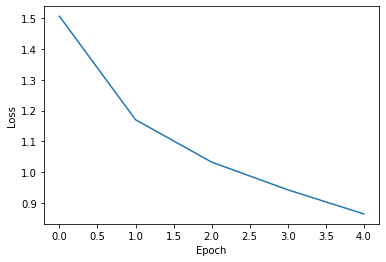

In [11]:
device = torch.device("cuda" if use_cuda else "cpu")
net = Conv_net().to(device)
EPOCHS_TO_TRAIN = 5
train(model=net, 
      train_dataset=train_loader, 
      epochs=EPOCHS_TO_TRAIN, 
      criterion=nn.CrossEntropyLoss(), 
      optimizer=optim.Adam(net.parameters(), lr=0.001))

In [16]:
test(model=net,device=device,test_loader=test_loader)


Test set: Average loss: -0.5797, Accuracy: 6882/10000 (69%)

